# NLE Assignment: Sentiment Classification

In this assignment, you will be investigating NLP methods for distinguishing positive and negative reviews written about movies.

For assessment, you are expected to complete and submit this notebook file.  When answers require code, you may import and use library functions (unless explicitly told otherwise).  All of your own code should be included in the notebook rather than imported from elsewhere.  Written answers should also be included in the notebook.  You should insert as many extra cells as you want and change the type between code and markdown as appropriate.

In order to avoid misconduct, you should not talk about the assignment questions with your peers.  If you are not sure what a question is asking you to do or have any other questions, please ask me or one of the Teaching Assistants.

Marking guidelines are provided as a separate document.

The first few cells contain code to set-up the assignment and bring in some data.   In order to provide unique datasets for analysis by different students, you must enter your candidate number in the following cell.  Otherwise do not change the code in these cells.

In [34]:
candidateno=233814 #this MUST be updated to your candidate number so that you get a unique data sample


In [35]:
#do not change the code in this cell
#preliminary imports

#set up nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('movie_reviews')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import movie_reviews

#for setting up training and testing data
import random

#useful other tools
import re
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import zip_longest
from nltk.probability import FreqDist
from nltk.classify.api import ClassifierI


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


In [36]:
#do not change the code in this cell
def split_data(data, ratio=0.7): # when the second argument is not given, it defaults to 0.7
    """
    Given corpus generator and ratio:
     - partitions the corpus into training data and test data, where the proportion in train is ratio,

    :param data: A corpus generator.
    :param ratio: The proportion of training documents (default 0.7)
    :return: a pair (tuple) of lists where the first element of the 
            pair is a list of the training data and the second is a list of the test data.
    """
    
    data = list(data)  
    n = len(data)  
    train_indices = random.sample(range(n), int(n * ratio))          
    test_indices = list(set(range(n)) - set(train_indices))    
    train = [data[i] for i in train_indices]           
    test = [data[i] for i in test_indices]             
    return (train, test)                       
 

def get_train_test_data():
    
    #get ids of positive and negative movie reviews
    pos_review_ids=movie_reviews.fileids('pos')
    neg_review_ids=movie_reviews.fileids('neg')
   
    #split positive and negative data into training and testing sets
    pos_train_ids, pos_test_ids = split_data(pos_review_ids)
    neg_train_ids, neg_test_ids = split_data(neg_review_ids)
    #add labels to the data and concatenate
    training = [(movie_reviews.words(f),'pos') for f in pos_train_ids]+[(movie_reviews.words(f),'neg') for f in neg_train_ids]
    testing = [(movie_reviews.words(f),'pos') for f in pos_test_ids]+[(movie_reviews.words(f),'neg') for f in neg_test_ids]
   
    return training, testing

When you have run the cell below, your unique training and testing samples will be stored in `training_data` and `testing_data`

In [37]:
#do not change the code in this cell
random.seed(candidateno)
training_data,testing_data=get_train_test_data()
print("The amount of training data is {}".format(len(training_data)))
print("The amount of testing data is {}".format(len(testing_data)))
print("The representation of a single data item is below")
print(training_data[0])

The amount of training data is 1400
The amount of testing data is 600
The representation of a single data item is below
(['"', 'footloose', '"', 'has', 'only', 'one', 'goal', ...], 'pos')


1)  
a) **Generate** a list of 10 content words which are representative of the positive reviews in your training data.

b) **Generate** a list of 10 content words which are representative of the negative reviews in your training data.

c) **Explain** what you have done and why

[20\%]

In [38]:
# separates the data into positive and negative review lists
def split_pos_neg(training_data):
  pos_data = []
  neg_data = []
  for review in training_data:
    words = review[0]
    if review[1] == 'pos':
      tup = (words,'pos')
      pos_data.append(tup)
    if review[1] == 'neg':
      tup = (words,'neg')
      neg_data.append(tup)
  return pos_data, neg_data 
  
pos_data,neg_data = split_pos_neg(training_data)

In [39]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
stop_words = stopwords.words('english')
import collections
from collections import Counter

#normalises the positive data by removing non alphabetic characters, removing stopwords and stemming the words
def normalise_data(data):
  normalised_data = []
  for x in data:
    words = x[0]
    words = [word for word in words if word.isalpha()]
    words = [word for word in words if word not in stop_words]
    words = [stemmer.stem(word) for word in words]
    tup = (words, x[1])
    normalised_data.append(tup)
  return normalised_data

normalisedpos_data = normalise_data(pos_data)
normalisedneg_data = normalise_data(neg_data)

# produces a frequency distribution for the words in each normalised review
def produce_dict(data):
  wordfreqdict = {}
  for review in data:
    words = review[0]
    for word in words:
      if word not in wordfreqdict.keys():
          wordfreqdict[word] = 1
      else:
          wordfreqdict[word] += 1
  return wordfreqdict

poswordfreq = produce_dict(normalisedpos_data)
negwordfreq = produce_dict(normalisedneg_data)


In [40]:
# This function gets the top words that occur more in positive or negative data
def most_frequent_words(dict1,dict2,k):
  dict1copy = dict(dict1)
  for key in dict1:
    if key in dict2:
      dict1copy[key] = dict1[key]- dict2[key]
  return dict(Counter(dict1copy).most_common(k))       

generated_pos_list = most_frequent_words(poswordfreq,negwordfreq,10)
generated_neg_list = most_frequent_words(negwordfreq,poswordfreq,10)

print("positive word list: {}".format(generated_pos_list))
print("negative word list: {}".format(generated_neg_list))


positive word list: {'film': 781, 'life': 396, 'also': 319, 'great': 274, 'well': 269, 'perform': 250, 'love': 242, 'charact': 235, 'mani': 234, 'war': 230}
negative word list: {'bad': 471, 'movi': 326, 'plot': 218, 'look': 201, 'even': 199, 'bore': 165, 'worst': 147, 'wast': 146, 'script': 144, 'suppos': 144}


I separated the data into positive and negative data sets. I then normalised the data by filtering out stopwords and non alphabetic characters and stemming the words. I produced frequency distributions for the positive and negative reviews sets and then defined a most_common_words function to get the 10 words that occur more in one data set than the other which are the most useful words

2) 
a) **Use** the lists generated in Q1 to build a **word list classifier** which will classify reviews as being positive or negative.

b) **Explain** what you have done.

[12.5\%]


In [41]:
from nltk.classify.api import ClassifierI
import random

class SimpleClassifier(ClassifierI): 

    def __init__(self, pos, neg): 
        self._pos = pos 
        self._neg = neg 

    def classify(self, words): 
        score = 0
        for word in words:
          word = stemmer.stem(word) 
          if word in self._pos:
            score = score + 1
          if word in self._neg:
            score = score - 1
        
        if score < 0:
          return 'neg'
        if score > 0:
          return 'pos'
        else: random.choice(['pos', 'neg'])

    ##we don't actually need to define the classify_many method as it is provided in ClassifierI
    #def classify_many(self, docs): 
    #    return [self.classify(doc) for doc in docs] 

    def labels(self): 
        return ("pos", "neg")

classifier = SimpleClassifier(generated_pos_list, generated_neg_list)      

I looped through the words that are input to the classifier and checked if that word was in the negative or positive word list. If it was in the positive list the score variable would be incremented and if negative score would be decremented. If score was ultimately above 0 the review would be labelled 'pos', if below it would be 'neg' and if it was 0 then a label would be randomly chosen between pos and neg.

3)
a) **Calculate** the accuracy, precision, recall and F1 score of your classifier.

b) Is it reasonable to evaluate the classifier in terms of its accuracy?  **Explain** your answer and give a counter-example (a scenario where it would / would not be reasonable to evaluate the classifier in terms of its accuracy).

[20\%]

In [42]:
from nltk.metrics.scores import precision, recall, f_measure
accuracy = nltk.classify.accuracy(classifier, testing_data)
print("accuracy: {}".format(accuracy))

reference = collections.defaultdict(set)
test = collections.defaultdict(set)

# gets the precision recall and f1 score
for i, (feats, label) in enumerate(testing_data):
    reference[label].add(i)
    observed = classifier.classify(feats)
    test[observed].add(i)
print('Precision:',precision(reference['pos'], test['pos']))
print('Recall:',recall(reference['pos'], test['pos']))
print('f1 score:',f_measure(reference['pos'], test['pos']))

accuracy: 0.615
Precision: 0.603448275862069
Recall: 0.8166666666666667
f1 score: 0.6940509915014165


It is reasonable to evaluate this classifier by accuracy because the training data is well balanced; the number of positive and negative reviews used to train the classifier are the same. It would not be reasonable for something like spam email classification because a classifier could predict all emails to not be spam and get a high accuracy.

4) 
a)  **Construct** a Naive Bayes classifier (e.g., from NLTK).

b)  **Compare** the performance of your word list classifier with the Naive Bayes classifier.  **Discuss** your results. 

[12.5\%]

In [43]:
from nltk.classify import NaiveBayesClassifier

# constructs and train a Naive Bayes classifier
def word_feats(words):
    return dict([(word, True) for word in words if word not in stop_words])
pos_feats = [(word_feats(f[0]), 'pos') for f in normalisedpos_data ]
neg_feats = [(word_feats(f[0]), 'neg') for f in normalisedneg_data ]
testing_feats = [(word_feats(f[0]), f[1]) for f in testing_data]
trainfeats = pos_feats + neg_feats
nbclassifier = NaiveBayesClassifier.train(trainfeats)    

In [44]:
print("naive bayes classifier accuracy :",nltk.classify.accuracy(nbclassifier, testing_feats))

naive bayes classifier accuracy : 0.6966666666666667


The accuracy of the naive bayes classifier is higher than the accuracy of the word list and as the data is balances accuracy is a good measure of the performance of a classifier on this data

5) 
a) Design and **carry out an experiment** into the impact of the **length of the wordlists** on the wordlist classifier.  Make sure you **describe** design decisions in your experiment, include a **graph** of your results and **discuss** your conclusions. 

b) Would you **recommend** a wordlist classifier or a Naive Bayes classifier for future work in this area?  **Justify** your answer.

[25\%]


I used 10 list lengths in my experiment from 5 to 50 in increments of 5. Accuracy is the only measure used because the classes are balanced. From my results i have found that my graph has bimodial distribution and the two modes are 10 and 30 words. Less than 10 words is suboptimal and so is more than 30 words as the accuracy goes down.

In [45]:
posi_data,nega_data = split_pos_neg(training_data)
train_train_pos = posi_data[:490] 
train_test = posi_data[-210:] + nega_data[-210:]
train_train_neg = nega_data[:490]
train_train_pos_n = normalise_data(train_train_pos)
train_train_neg_n = normalise_data(train_train_neg)

In [46]:
pos_dict = produce_dict(train_train_pos_n)
neg_dict = produce_dict(train_train_neg_n)


pos_train_list1 = most_frequent_words(pos_dict,neg_dict,5)
pos_train_list2 = most_frequent_words(pos_dict,neg_dict,10)
pos_train_list3 = most_frequent_words(pos_dict,neg_dict,15)
pos_train_list4 = most_frequent_words(pos_dict,neg_dict,20)
pos_train_list5 = most_frequent_words(pos_dict,neg_dict,25)
pos_train_list6 = most_frequent_words(pos_dict,neg_dict,30)
pos_train_list7 = most_frequent_words(pos_dict,neg_dict,35)
pos_train_list8 = most_frequent_words(pos_dict,neg_dict,40)
pos_train_list9 = most_frequent_words(pos_dict,neg_dict,45)
pos_train_list10 = most_frequent_words(pos_dict,neg_dict,50)

neg_train_list1 = most_frequent_words(neg_dict,pos_dict,5)
neg_train_list2 = most_frequent_words(neg_dict,pos_dict,10)
neg_train_list3 = most_frequent_words(neg_dict,pos_dict,15)
neg_train_list4 = most_frequent_words(neg_dict,pos_dict,20)
neg_train_list5 = most_frequent_words(neg_dict,pos_dict,25)
neg_train_list6 = most_frequent_words(neg_dict,pos_dict,30)
neg_train_list7 = most_frequent_words(neg_dict,pos_dict,35)
neg_train_list8 = most_frequent_words(neg_dict,pos_dict,40)
neg_train_list9 = most_frequent_words(neg_dict,pos_dict,45)
neg_train_list10 = most_frequent_words(neg_dict,pos_dict,50)

wlclassifier1 = SimpleClassifier(pos_train_list1,neg_train_list1)
wlclassifier2 = SimpleClassifier(pos_train_list2,neg_train_list2)
wlclassifier3 = SimpleClassifier(pos_train_list3,neg_train_list3)
wlclassifier4 = SimpleClassifier(pos_train_list4,neg_train_list4)
wlclassifier5 = SimpleClassifier(pos_train_list5,neg_train_list5)
wlclassifier6 = SimpleClassifier(pos_train_list6,neg_train_list6)
wlclassifier7 = SimpleClassifier(pos_train_list7,neg_train_list7)
wlclassifier8 = SimpleClassifier(pos_train_list8,neg_train_list8)
wlclassifier9 = SimpleClassifier(pos_train_list9,neg_train_list9)
wlclassifier10 = SimpleClassifier(pos_train_list10,neg_train_list10)

wlaccuracy1 = nltk.classify.accuracy(wlclassifier1, train_test)
wlaccuracy2 = nltk.classify.accuracy(wlclassifier2, train_test)
wlaccuracy3 = nltk.classify.accuracy(wlclassifier3, train_test)
wlaccuracy4 = nltk.classify.accuracy(wlclassifier4, train_test)
wlaccuracy5 = nltk.classify.accuracy(wlclassifier5, train_test)
wlaccuracy6 = nltk.classify.accuracy(wlclassifier6, train_test)
wlaccuracy7 = nltk.classify.accuracy(wlclassifier7, train_test)
wlaccuracy8 = nltk.classify.accuracy(wlclassifier8, train_test)
wlaccuracy9 = nltk.classify.accuracy(wlclassifier9, train_test)
wlaccuracy10 = nltk.classify.accuracy(wlclassifier10, train_test)

print(wlaccuracy1)
print(wlaccuracy2)
print(wlaccuracy3)
print(wlaccuracy4)
print(wlaccuracy5)
print(wlaccuracy6)
print(wlaccuracy7)
print(wlaccuracy8)
print(wlaccuracy9)
print(wlaccuracy10)

0.5785714285714286
0.6309523809523809
0.6214285714285714
0.6142857142857143
0.6142857142857143
0.6309523809523809
0.6166666666666667
0.6023809523809524
0.5904761904761905
0.6


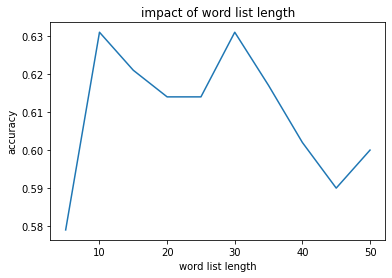

In [47]:
import matplotlib.pyplot as plt
x = [5,10,15,20,25,30,35,40,45,50]
y = [0.579,0.631,0.621,0.614,0.614,0.631,0.617,0.602,0.590,0.6]

plt.plot(x,y)
plt.title("impact of word list length")
plt.xlabel("word list length")
plt.ylabel("accuracy")
plt.show()

I would recommend the naive bayes classifier over the word list classifier because even at the optimal length of 10 words the naive bayes outperforms the word list classifier on accuracy

In [48]:
##This code will word count all of the markdown cells in the notebook saved at filepath
##Running it before providing any answers shows that the questions have a word count of 437

import io
from nbformat import current

#filepath="/content/drive/My Drive/NLE Notebooks/assessment/assignment1.ipynb"
filepath="NLassignment2022.ipynb"
question_count=437

with io.open(filepath, 'r', encoding='utf-8') as f:
    nb = current.read(f, 'json')

word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
print("Submission length is {}".format(word_count-question_count))

FileNotFoundError: ignored